# Original Strategy 1

## Importing Data
### Stock: NVDA \ Period: 1Y, Interval: 1D

In [17]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

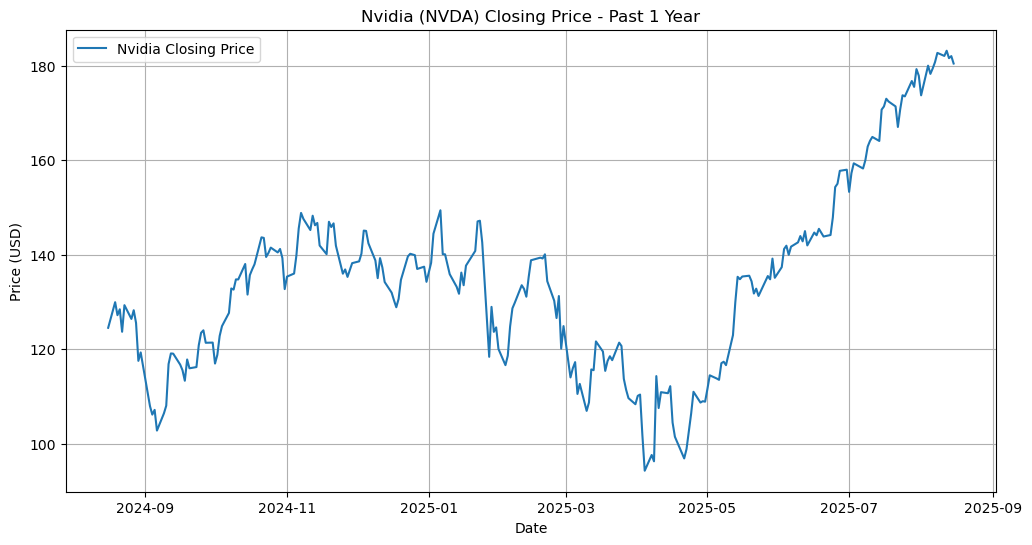

In [27]:
nvda = yf.Ticker("NVDA")

data = nvda.history(period = "1y", interval = "1d")

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Nvidia Closing Price')
plt.title('Nvidia (NVDA) Closing Price - Past 1 Year')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


## Strategy Implementation
### This strategy is a **probabilistic, adaptive trading approach** that uses two separate “risk parameters” to guide buying and selling. One parameter (`R_up`) controls the probability of selling when the stock price is rising, and the other (`R_down`) controls the probability of buying when the price is falling. After each trade, the corresponding risk parameter is adjusted based on whether the action was profitable, so the strategy gradually favors more successful decisions. Any remaining shares are sold at the end of the period to capture final gains. Over time, this creates a feedback loop where the strategy learns from past outcomes, balancing risk and reward while adapting to the stock’s behavior.


In [8]:
# for reference
print(data.head(3))

                                 Open        High         Low       Close  \
Date                                                                        
2024-08-16 00:00:00-04:00  121.901491  124.960523  121.141729  124.540657   
2024-08-19 00:00:00-04:00  124.240744  129.958939  123.381015  129.958939   
2024-08-20 00:00:00-04:00  128.359439  129.838983  125.850237  127.209808   

                              Volume  Dividends  Stock Splits  
Date                                                           
2024-08-16 00:00:00-04:00  302589900        0.0           0.0  
2024-08-19 00:00:00-04:00  318333600        0.0           0.0  
2024-08-20 00:00:00-04:00  300087400        0.0           0.0  


Total Revenue from adaptive dual-risk strategy: $2698.26


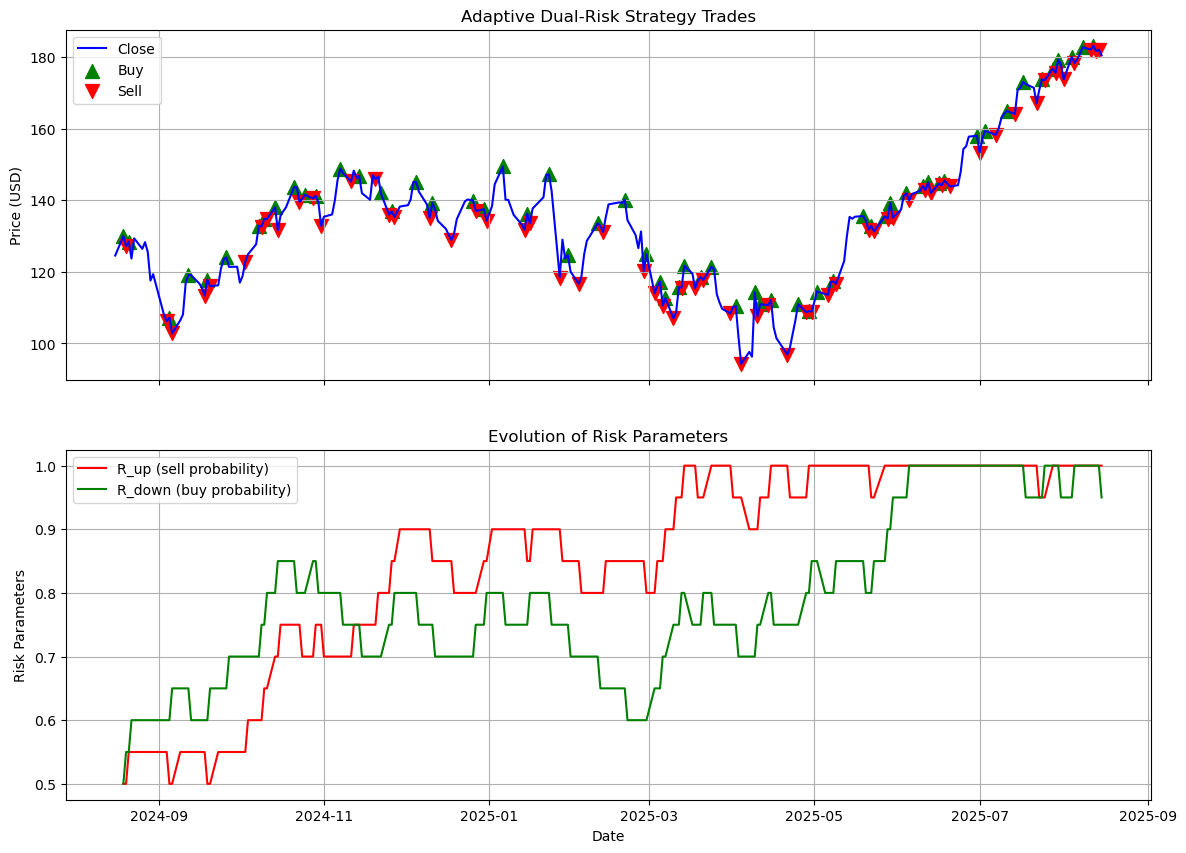

In [29]:
# --- Initialize variables ---
volume = 100
position = 0
buy_price = 0
revenue = 0

# Risk parameters (probabilities)
R_up = 0.5    # probability to sell when price is going up
R_down = 0.5  # probability to buy when price is going down
alpha = 0.05  # adjustment step for risk parameters

# Store history for analysis
R_up_history = []
R_down_history = []
trade_history = []  # 1=buy, -1=sell, 0=hold
diff_history = []   # difference between actual and optimal action revenue

for i in range(1, len(data)):
    trend_up = data['Close'].iloc[i] > data['Close'].iloc[i-1]
    trend_down = data['Close'].iloc[i] < data['Close'].iloc[i-1]
    price = data['Close'].iloc[i]
    optimal_revenue_diff = 0
    
    # Decision logic
    if trend_up and position == 1:
        # Uptrend and holding shares: probabilistic sell
        if np.random.rand() < R_up:
            sell_price = price
            trade_revenue = (sell_price - buy_price) * volume
            revenue += trade_revenue
            position = 0
            trade_history.append(-1)
            
            # Optimal decision difference
            optimal_revenue_diff = trade_revenue - 0  # selling was optimal
            # Adjust R_up
            R_up = min(R_up + alpha, 1.0) if trade_revenue > 0 else max(R_up - alpha, 0.0)
        else:
            trade_history.append(0)
    
    elif trend_down and position == 0:
        # Downtrend and not holding shares: probabilistic buy
        if np.random.rand() < R_down:
            buy_price = price
            position = 1
            trade_history.append(1)
            
            # Optimal decision difference
            # If price goes up next, buying is optimal
            future_price_change = data['Close'].iloc[i+1] - price if i+1 < len(data) else 0
            optimal_revenue_diff = future_price_change * volume
            # Adjust R_down
            R_down = min(R_down + alpha, 1.0) if future_price_change > 0 else max(R_down - alpha, 0.0)
        else:
            trade_history.append(0)
    else:
        trade_history.append(0)
    
    # Store risk parameters and difference
    R_up_history.append(R_up)
    R_down_history.append(R_down)
    diff_history.append(optimal_revenue_diff)

# Close any open position at the end
if position == 1:
    sell_price = data['Close'].iloc[-1]
    revenue += (sell_price - buy_price) * volume
    trade_history[-1] = -1  # mark final sell

print(f"Total Revenue from adaptive dual-risk strategy: ${revenue:.2f}")

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# Top: Close price with buy/sell markers
ax1.plot(data.index, data['Close'], label='Close', color='blue')
buy_idx = [i for i, t in enumerate(trade_history) if t == 1]
sell_idx = [i for i, t in enumerate(trade_history) if t == -1]
ax1.scatter(data.index[buy_idx], data['Close'].iloc[buy_idx], marker='^', color='green', s=100, label='Buy')
ax1.scatter(data.index[sell_idx], data['Close'].iloc[sell_idx], marker='v', color='red', s=100, label='Sell')
ax1.set_ylabel('Price (USD)')
ax1.set_title('Adaptive Dual-Risk Strategy Trades')
ax1.legend()
ax1.grid(True)

# Bottom: Risk parameter evolution
ax2.plot(data.index[1:], R_up_history, label='R_up (sell probability)', color='red')
ax2.plot(data.index[1:], R_down_history, label='R_down (buy probability)', color='green')
ax2.set_ylabel('Risk Parameters')
ax2.set_xlabel('Date')
ax2.set_title('Evolution of Risk Parameters')
ax2.legend()
ax2.grid(True)

plt.show()